In [1]:
import sys
import os

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')
))

from model import ResNet50

WEIGHT_PTH = '../checkpoint/best_model_IMAGENET_ResNet50_False_ckpt.tar'
NUM_CLASSES = 1000
N_FRAMES = 3
STEM = False
DATASET = 'IMAGENET'
DATADIR = '../../../datasets/EPIC_KITCHENS_2018/frames_256/P01_01/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Model
model = ResNet50(num_classes=NUM_CLASSES, stem=STEM, dataset=DATASET)
model.load_state_dict(torch.load(WEIGHT_PTH)['state_dict'])
model = model.to(DEVICE)
model.eval()

# Dataloader
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        DATADIR,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
    batch_size=1, shuffle=False,
    num_workers=8, pin_memory=True)

# Deprocess
def deprocess(x):
    x = x.permute([1, 2, 0]).cpu().numpy()
    x *= np.array([0.229, 0.224, 0.225])
    x += np.array([0.485, 0.456, 0.406])
    x = (x*255).astype(np.uint8)
    return x

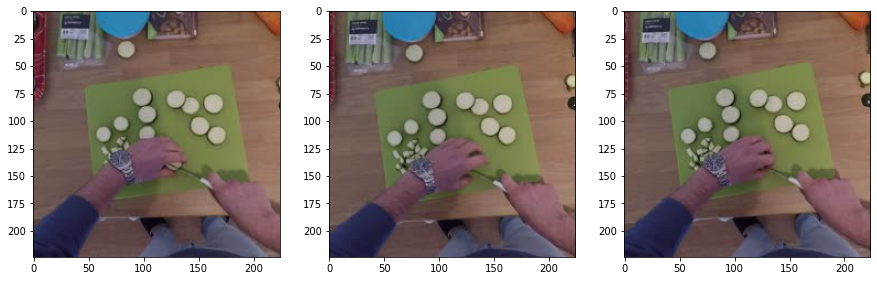

In [3]:
with torch.no_grad():
    data = []
    start_ix, step = 1500, 20
    for i in range(N_FRAMES):
        frame, _ = dataloader.dataset[start_ix + i*step]
        data.append(frame)
        
    data = torch.stack(data).to(DEVICE)
    model(data)
    attn_dict = model.get_all_attention()

fig, axes = plt.subplots(1, N_FRAMES, figsize=(15, 10))
for t in range(N_FRAMES):
    axes[t].imshow(deprocess(data[t]))

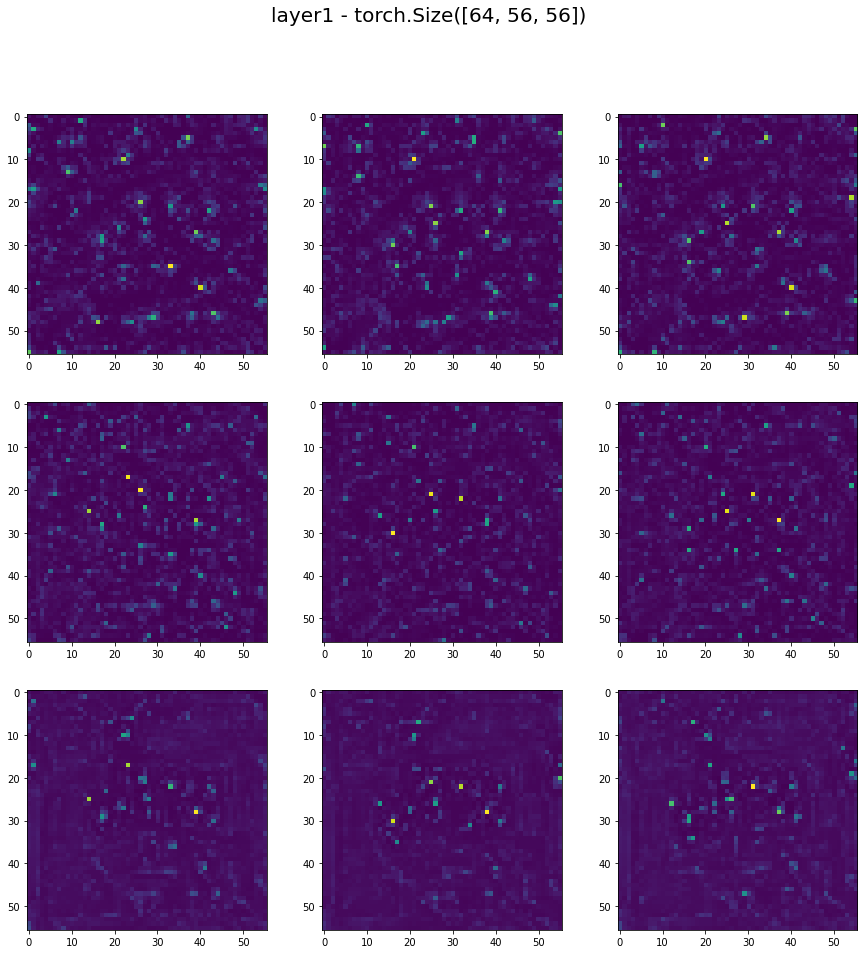

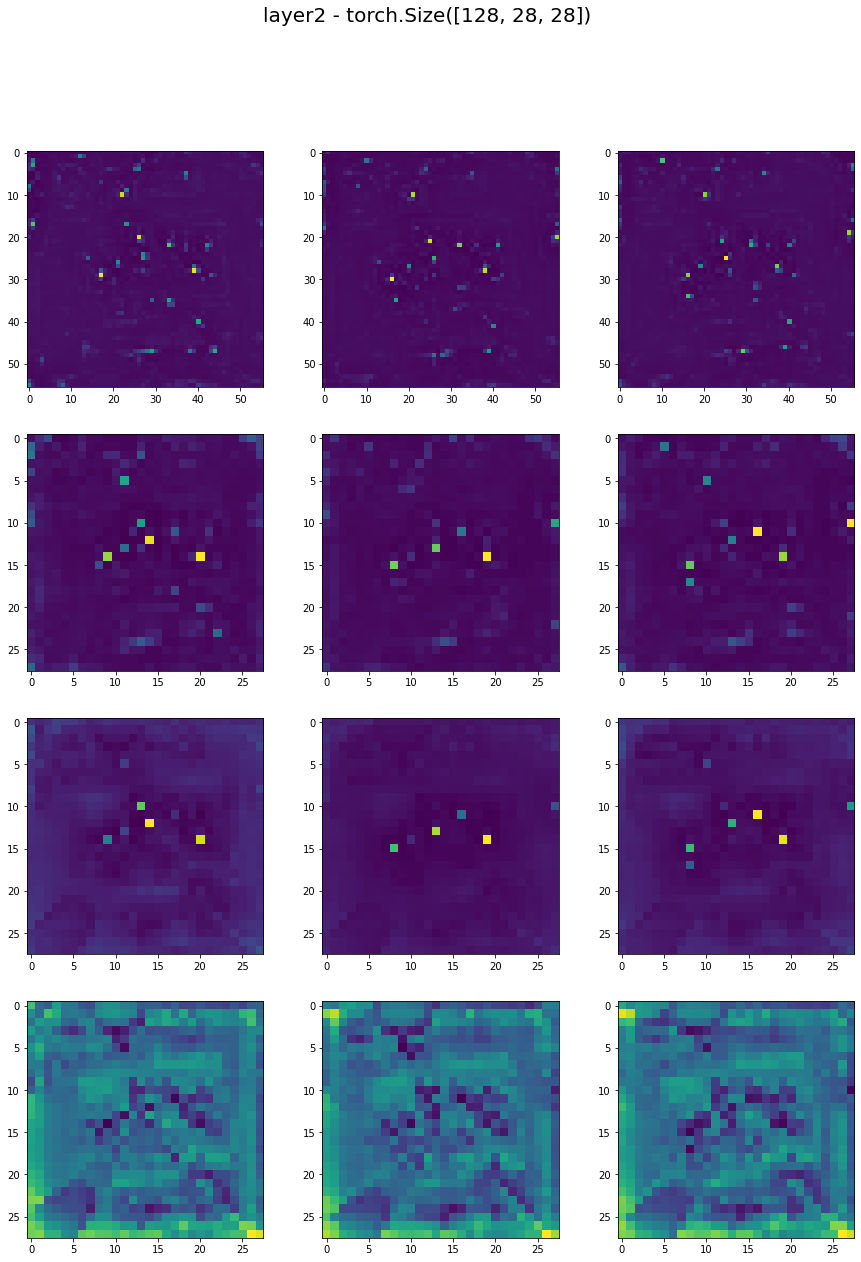

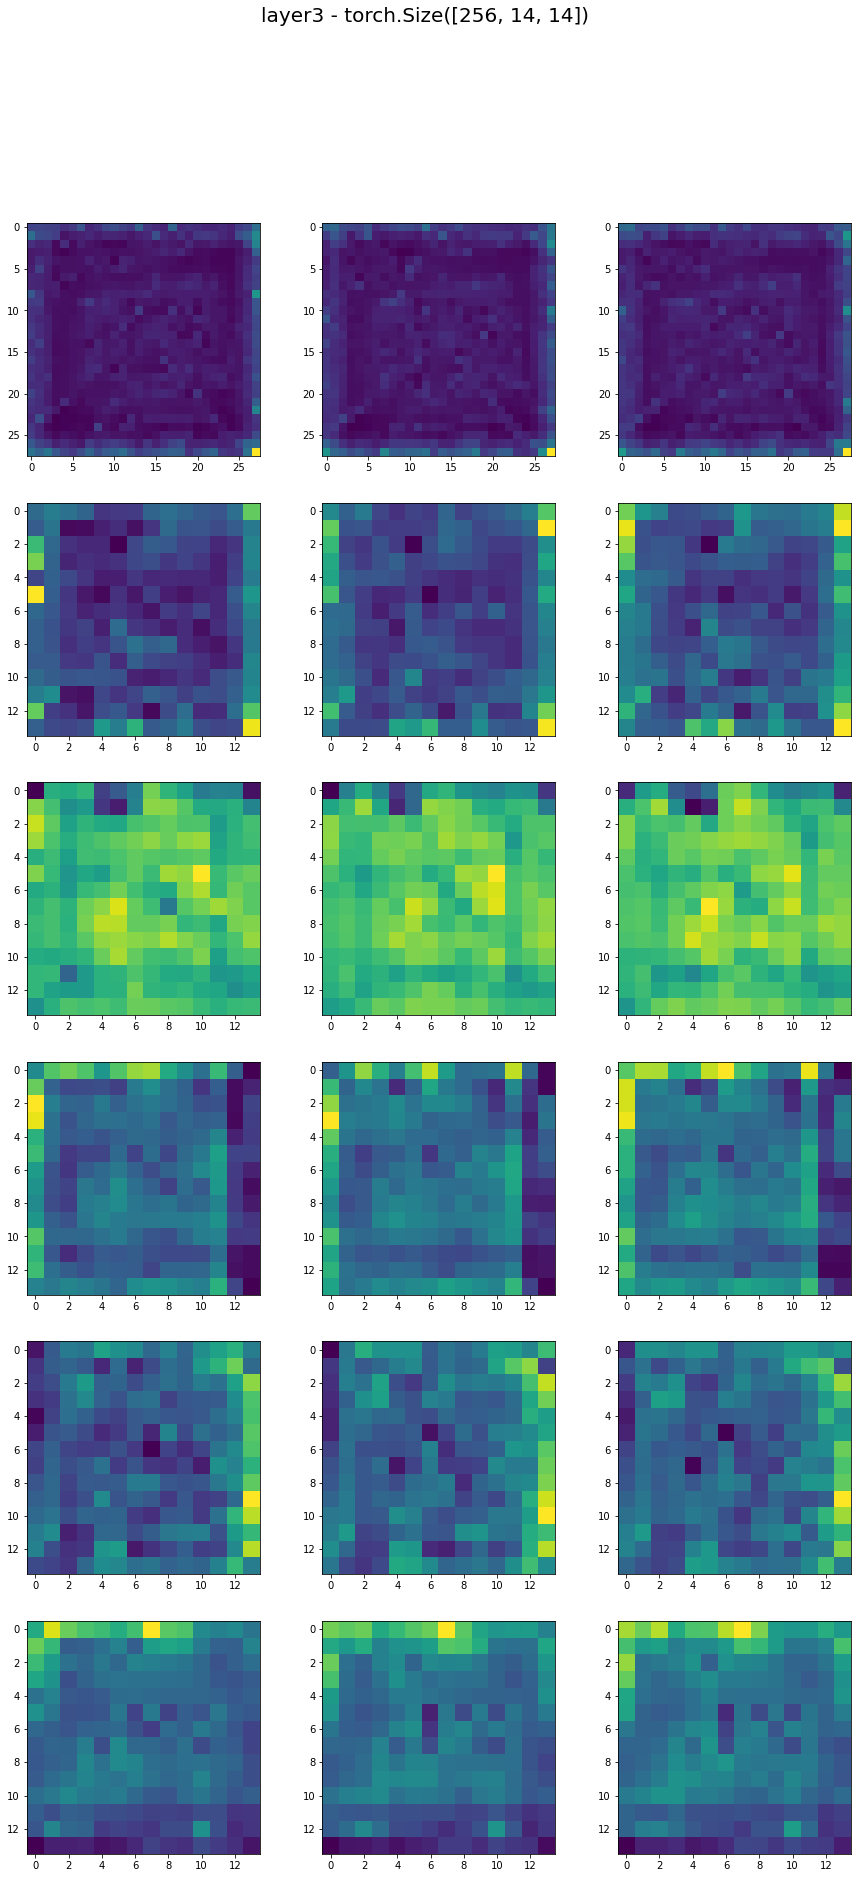

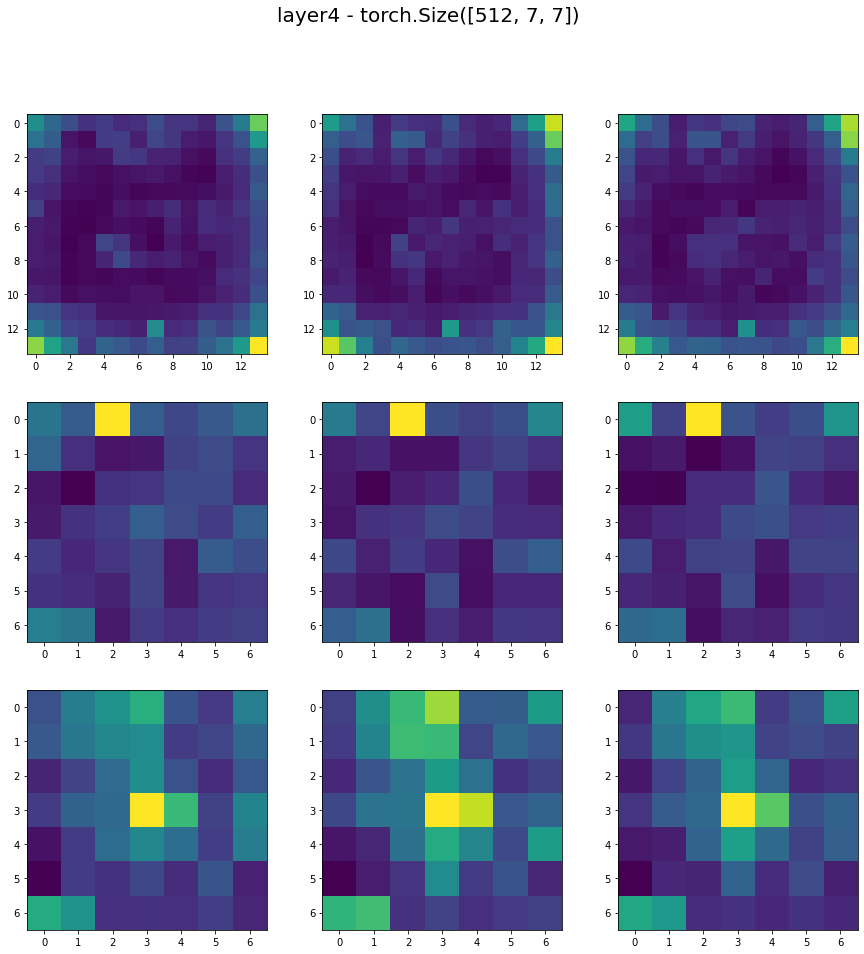

In [4]:
layer_lst = list(attn_dict.keys())
for layer in layer_lst:
    module_lst = list(attn_dict[layer].keys())
    fig, axes = plt.subplots(len(module_lst), N_FRAMES, figsize=(15, len(module_lst)*5))
    for m, module in enumerate(module_lst):
        for t in range(N_FRAMES):
            axes[m, t].imshow(attn_dict[layer][module][t].mean(dim=0).cpu().numpy())
    plt.suptitle(layer + ' - ' + str(attn_dict[layer][module][t].shape), fontsize=20)